# Decoder-Only Transformer Language Model Implementation

Inspired by the exercise from https://github.com/jacobhilton/deep_learning_curriculum/blob/master/1-Transformers.md

In [1]:
import torch
import torch.nn as nn

In [2]:
!pip install einops
import einops

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 2.7 MB/s eta 0:00:00


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Masked Self-Attention

We move on to implementing the attention mechanism: $softmax(\frac{QK}{\sqrt(d_k)})V$ and mask such that a token cannot attend to future tokens.

Note in the tensors Q, K, and V, we order the dimensions 'batch pos n_heads d_head' instead of the more intuitive 'batch n_heads pos d_head' in order to take advantage of broadcasting rules for the bias terms.

In [4]:
class Attention(nn.Module):
  def __init__(self, cfg):
    super().__init__()
    self.cfg = cfg
    self.W_Q = nn.Parameter(torch.empty(cfg.n_heads, cfg.d_model, cfg.d_head))
    self.W_K = nn.Parameter(torch.empty(cfg.n_heads, cfg.d_model, cfg.d_head))
    self.W_V = nn.Parameter(torch.empty(cfg.n_heads, cfg.d_model, cfg.d_head))
    self.W_O = nn.Parameter(torch.empty(cfg.n_heads, cfg.d_head, cfg.d_model))
    self.b_Q = nn.Parameter(torch.zeros(cfg.n_heads, cfg.d_head))
    self.b_K = nn.Parameter(torch.zeros(cfg.n_heads, cfg.d_head))
    self.b_V = nn.Parameter(torch.zeros(cfg.n_heads, cfg.d_head))
    self.b_O = nn.Parameter(torch.zeros(cfg.d_model))
    self.register_buffer("IGNORE", torch.tensor(-1e5, dtype=torch.float32, device=device))

  def forward(self, x):
    Q = einops.einsum(x, self.W_Q,
                      'batch pos d_model, n_heads d_model d_head -> \
                      batch pos n_heads d_head') + self.b_Q
    K = einops.einsum(x, self.W_K,
                      'batch pos d_model, n_heads d_model d_head -> \
                      batch pos n_heads d_head') + self.b_K
    V = einops.einsum(x, self.W_V,
                      'batch pos d_model, n_heads d_model d_head -> \
                      batch pos n_heads d_head') + self.b_V

    # Calculate attention scores, then scale and mask
    attn_scores = einops.einsum(Q, K,
                                'batch pos_Q n_heads d_head, \
                                batch pos_K n_heads d_head -> \
                                batch n_heads pos_Q pos_K')

    attn_scores_masked = self.apply_causal_mask(attn_scores / self.cfg.d_head ** 0.5)

    attn_pattern = attn_scores_masked.softmax(-1)

    # Take weighted sum of values based on attention pattern
    v_sum = einops.einsum(attn_pattern, V,
                          'batch n_heads pos_Q pos_K, \
                          batch pos_K n_heads d_head -> \
                          batch pos_Q n_heads d_head')

    # Calculate output
    return einops.einsum(v_sum, self.W_O,
                         'batch pos_Q n_heads d_head, \
                         n_heads d_head d_model -> \
                         batch pos_Q d_model') + self.b_O

  def apply_causal_mask(self, attention_scores):
    ones = torch.ones(attention_scores.shape[-2], attention_scores.shape[-1], device=attention_scores.device)
    mask = torch.triu(ones, diagonal=1).bool()

    return attention_scores.masked_fill_(mask, self.IGNORE)

## MLP

Next we implement a MLP class that first projects the input to a higher dimension, applies a nonlinearity, and then reprojects it back down to the model dimension.

In [5]:
class MLP(nn.Module):
  def __init__(self, cfg):
    super().__init__()
    self.cfg = cfg
    self.W1 = nn.Parameter(torch.empty(cfg.d_model, cfg.d_mlp))
    self.W2 = nn.Parameter(torch.empty(cfg.d_mlp, cfg.d_model))
    self.b1 = nn.Parameter(torch.zeros(cfg.d_mlp))
    self.b2 = nn.Parameter(torch.zeros(cfg.d_model))
    self.activation_fn = cfg.activation_fn

  def forward(self, x):
    x = einops.einsum(x, self.W1,
                      'batch pos d_model, d_model d_mlp -> batch pos d_mlp') + self.b1
    x = self.activation_fn(x)
    x = einops.einsum(x, self.W2,
                      'batch pos d_mlp, d_mlp d_model -> batch pos d_model') + self.b2
    return x

## LayerNorm

While we could simply use PyTorch's implementation of [LayerNorm](https://pytorch.org/docs/stable/generated/torch.nn.LayerNorm.html), let's implement it from scratch to get a deeper understanding of it.

In [6]:
class LayerNorm(nn.Module):
  def __init__(self, cfg):
    super().__init__()
    self.cfg = cfg
    self.gamma = nn.Parameter(torch.ones(cfg.d_model))
    self.beta = nn.Parameter(torch.zeros(cfg.d_model))

  def forward(self, x): # [batch, pos, d_model]
    mean = x.mean(dim=-1, keepdims=True)
    var = x.var(dim=-1, keepdims=True, unbiased=False)
    eps = torch.tensor(1e-5)
    return (x - mean) / (var + eps).sqrt() * self.gamma + self.beta

## Transformer Block

In [7]:
class TransformerBlock(nn.Module):
  def __init__(self, cfg):
    super().__init__()
    self.attention_heads = Attention(cfg)
    self.mlp = MLP(cfg)
    self.ln1 = LayerNorm(cfg)
    self.ln2 = LayerNorm(cfg)

  def forward(self, x):
    x_mid = self.attention_heads(self.ln1(x)) + x
    x_post = self.mlp(self.ln2(x)) + x_mid
    return x_post

## Positional Embedding

We implement the sinusoidal positional embeddings described in the original Vaswani et al. paper, although learned embeddings can also be used.

$P(k,2i)=sin(\frac{k}{n^{2i/d}}​)$

$P(k,2i+1)=cos⁡(\frac{k}{n^{2i/d}})$

- k: Position of an object in the input sequence
- d: Dimension of the output embedding space
- P(k,j): Position function for mapping a position k in the input sequence to index (k,j) of the positional matrix
- n: User-defined scalar (e.g., set to 10,000 by the authors)
- i: Used for mapping to column indices

where $n = 10000$

In [8]:
class PosEmbed(nn.Module):
  def __init__(self, cfg):
    super().__init__()
    self.cfg = cfg

  def forward(self, seq_len):
    assert(seq_len <= self.cfg.d_seq)
    input_positions = einops.rearrange(torch.arange(seq_len), 'd_seq -> d_seq 1')
    embedded_positions = einops.rearrange(torch.arange(self.cfg.d_model), 'd_model -> 1 d_model')
    angles = self.get_angles(input_positions, embedded_positions, self.cfg.d_model)
    angles[:, 0::2] = torch.sin(angles[:, 0::2])
    angles[:, 1::2] = torch.cos(angles[:, 1::2])
    embedding = einops.rearrange(angles, 'd_seq d_model -> 1 d_seq d_model') # for broadcasting
    return embedding.to(device)

  def get_angles(self, input_pos, output_pos, d_model):
    return input_pos / torch.pow(1e5, 2*(output_pos // 2) / float(d_model))

### Visualizing the position embedding

(1, 32, 128)


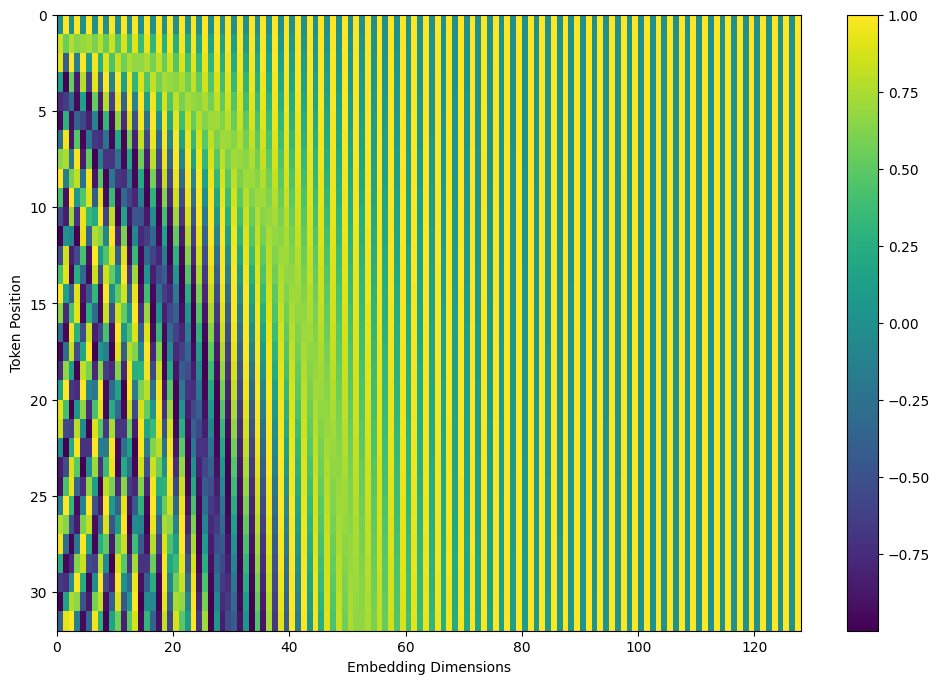

In [9]:
# mostly from https://github.com/jalammar/jalammar.github.io/blob/master/notebookes/transformer/transformer_positional_encoding_graph.ipynb
import numpy as np
import matplotlib.pyplot as plt

def positional_embedding(d_seq, d_model):
  def get_angles(k, i, d_model):
    return k / np.power(10000, (2*(i // 2) / float(d_model)))

  angles = get_angles(np.arange(d_seq)[:, np.newaxis],
                      np.arange(d_model)[np.newaxis, :],
                      d_model)

  angles[:, 0::2] = np.sin(angles[:, 0::2])
  angles[:, 1::2] = np.cos(angles[:, 1::2])

  return angles[np.newaxis, :]

tokens = 32
dimensions = 128

pos_embedding = positional_embedding(tokens, dimensions)
print (pos_embedding.shape)

plt.figure(figsize=(12,8))
plt.pcolormesh(pos_embedding[0], cmap='viridis')
plt.xlabel('Embedding Dimensions')
plt.xlim((0, dimensions))
plt.ylim((tokens,0))
plt.ylabel('Token Position')
plt.colorbar()
plt.show()

## Embedding and Unembedding

The embedding module is basically a lookup table from tokens (each represented as an integer) to embeddings to start the residual stream.

In [10]:
class Embed(nn.Module):
  def __init__(self, cfg):
    super().__init__()
    self.W = nn.Parameter(torch.empty(cfg.d_vocab, cfg.d_model))

  def forward(self, tokens):
    return self.W[tokens]

In [11]:
class Unembed(nn.Module):
  def __init__(self, cfg):
    super().__init__()
    self.W = nn.Parameter(torch.empty(cfg.d_model, cfg.d_vocab))
    self.b = nn.Parameter(torch.zeros(cfg.d_vocab))

  def forward(self, x): # [batch, pos, d_model] -> [batch, pos, d_vocab]
    x = einops.einsum(x, self.W,
                      'batch pos d_model, d_model d_vocab -> batch pos d_vocab') + self.b
    return x

## Putting It All Together

Let's now put together a complete transformer architecture, although in order to actually use it for a concrete task we'll also need a tokenizer.

In [12]:
class Transformer(nn.Module):
  def __init__(self, cfg):
    super().__init__()
    self.cfg = cfg
    self.embed = Embed(cfg)
    self.pos_embed = PosEmbed(cfg)
    self.blocks = nn.ModuleList(TransformerBlock(cfg) for _ in range(cfg.n_layers))
    self.final_ln = LayerNorm(cfg)
    self.unembed = Unembed(cfg)

  def forward(self, tokens): # [batch, pos] -> [batch, pos, d_model]
    x = self.embed(tokens) + self.pos_embed(tokens.size(1)) # [batch, pos, d_model]
    for block in self.blocks:
      x = block(x)                            # [batch, pos, d_model]
    x = self.final_ln(x)                      # [batch, pos, d_model]
    logits = self.unembed(x)                  # [batch, pos, d_vocab]
    return logits

# Attention Mask Validation: Reversing a Random Sequence of Tokens

To check that the attention mask is set up correctly, we train the model on a toy task, such as reversing a random sequence of tokens. The model should be able to predict the second half of the sequence, but not the first.


Let the tokens be random integers from 0 to 99 such that the vocab size is 100. Let's also set the other necessary configuration parameters:

### Generate a dataset

Now lets generate some training data. We want sequences of random integers of length 16, with the second half mirroring the first half. Here we generate 1000 sequences.

In [13]:
from torch.utils.data import Dataset, DataLoader

class RandomIntSeqDataset(Dataset):
  def __init__(self):
    rng = torch.Generator()
    rng.manual_seed(42)
    self.data = torch.randint(0, 100, (100000, 8), generator=rng)

  def __len__(self):
    return self.data.size(0)

  def __getitem__(self, idx):
    item = self.data[idx, :]
    return torch.hstack((item, torch.flip(item, [1])))

dataset = RandomIntSeqDataset()

In [14]:
train_size = int(len(dataset) * 0.8)
train_dl = DataLoader(dataset[:train_size], batch_size=64, shuffle=True, drop_last=True)
valid_dl = DataLoader(dataset[train_size:], batch_size=64, drop_last=True)

### Loss Function

Now lets define our loss function. In language models, we typically want to compare the predicted log-probabilities with the actual next token in the sequence. We exclude the log-probabilities for the last token in each sequence, as we don't have a "next token" to compare it with.

In [15]:
def get_log_probs(logits, tokens): # [batch, pos, d_vocab], [batch, pos] -> [batch, pos-1]
  log_probs = logits.log_softmax(dim=-1)

  # Get logprobs the first seq_len-1 predictions (so we can compare them with the actual next tokens)
  log_prob_correct = log_probs[:, :-1].gather(dim=-1, index=tokens[:, 1:].unsqueeze(-1)).squeeze(-1)

  ### Same as the following
  # actual = torch.nn.functional.one_hot(tokens[:, 1:].long(), num_classes=logits.size(-1))
  # log_prob_correct = (log_probs[:, :-1] * actual).sum(-1)

  return log_prob_correct


def cross_entropy_loss(logits, tokens):
  log_prob_correct = get_log_probs(logits, tokens)
  return -log_prob_correct.mean()

### Instantiate a model

In [16]:
class Config:
  def __init__(self):
    self.n_heads = 6
    self.d_head = 64
    self.d_model = self.n_heads * self.d_head
    self.n_layers = 6
    self.d_mlp = self.d_model * 4
    self.d_vocab = 100
    self.d_seq = 16
    self.activation_fn = torch.nn.ReLU()

In [17]:
cfg = Config()
transformer = Transformer(cfg)

def init_weights(m):
  std = 0.02
  if isinstance(m, Attention):
    torch.nn.init.normal_(m.W_Q, std=std)
    torch.nn.init.normal_(m.W_K, std=std)
    torch.nn.init.normal_(m.W_V, std=std)
    torch.nn.init.normal_(m.W_O, std=std)
  if isinstance(m, MLP):
    torch.nn.init.normal_(m.W1, std=std)
    torch.nn.init.normal_(m.W2, std=std)
  if isinstance(m, Embed):
    torch.nn.init.normal_(m.W, std=std)
  if isinstance(m, Unembed):
    torch.nn.init.normal_(m.W, std=std)

transformer.apply(init_weights)

Transformer(
  (embed): Embed()
  (pos_embed): PosEmbed()
  (blocks): ModuleList(
    (0-5): 6 x TransformerBlock(
      (attention_heads): Attention()
      (mlp): MLP(
        (activation_fn): ReLU()
      )
      (ln1): LayerNorm()
      (ln2): LayerNorm()
    )
  )
  (final_ln): LayerNorm()
  (unembed): Unembed()
)

### Trainer

Onto the training loop!

In [18]:
from tqdm.notebook import tqdm

In [19]:
class DataLoaders:
  def __init__(self, train_dataloader, valid_dataloader):
    self.train_dataloader = train_dataloader
    self.valid_dataloader = valid_dataloader

  def train_dl(self):
    return self.train_dataloader

  def valid_dl(self):
    return self.valid_dataloader

In [20]:
class Learner:
  def __init__(self, dataloaders, model, optimizer, loss_func,
               scheduler=None, gradient_accumulation_batch_size=64):
    self.dataloaders = dataloaders
    self.model = model.to(device)
    self.optimizer = optimizer
    for param_group in self.optimizer.param_groups:
      for param in param_group['params']:
          param.data = param.data.to(device)
    self.loss_func = loss_func
    self.scheduler = scheduler
    self.val_losses = []
    self.gradient_accumulation_bs = gradient_accumulation_batch_size
    self.gradient_accumulation_count = 0

  def fit(self, epochs):
    for epoch in tqdm(range(epochs)):
      self.model.train()
      train_loss = 0.
      for seqs in tqdm(self.dataloaders.train_dl()):
        seqs = seqs.to(device)
        preds = self.model(seqs)
        loss = self.loss_func(preds, seqs)
        train_loss += loss
        loss.backward()
        self.optimizer.step()
        self.gradient_accumulation_count += len(seqs)
        if self.gradient_accumulation_count - self.gradient_accumulation_bs > 0:
          self.gradient_accumulation_count = 0
          self.optimizer.zero_grad()
        if self.scheduler:
          self.scheduler.step()
      print("avg training loss: ", train_loss / len(self.dataloaders.train_dl()))

      self.model.eval()
      with torch.no_grad():
        val_losses = 0.
        metric_results = []
        for seqs in self.dataloaders.valid_dl():
          seqs = seqs.to(device)
          preds = self.model(seqs)
          val_losses += self.loss_func(preds, seqs)
        num_batches = len(self.dataloaders.valid_dl())
        print("avg validation loss: ", val_losses / num_batches)

### Train the model

Since we start with randomized weights and randomly generated data, we should expect the loss to start at a particular value, and be lower bounded by another value.

Since the integers in the sequence can take on any value from 0 to 99, an untrained model should have average loss around $-ln(\frac{1}{100}) ≈ 4.6$.

A trained model should be able to accurately predict the second half of each sequence, so the average loss for predicting a sequence of length $16$ should converge to $-ln(\frac{1}{100}) * \frac{7}{15} + -ln(\frac{1}{1}) * \frac{8}{15} \approx 2.149$.

The $15$ in the denominator comes from discarding the last prediction in the sequence since it has nothing to match with. The first $7$ elements of the sequence should not be predictable, but the 8th-15th prediction should match with the 1st-8th elements of the input.

In [21]:
dls = DataLoaders(train_dl, valid_dl)
epochs = 10
optimizer = torch.optim.Adam(transformer.parameters(), lr=1e-4)
loss_func = cross_entropy_loss
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=1e-3, steps_per_epoch=len(train_dl), epochs=epochs)
learner = Learner(
    dls, transformer.to(device), optimizer, loss_func, scheduler,
    gradient_accumulation_batch_size=64)
learner.fit(epochs)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

avg training loss:  tensor(4.6142, device='cuda:0', grad_fn=<DivBackward0>)
avg validation loss:  tensor(4.6100, device='cuda:0')


  0%|          | 0/1250 [00:00<?, ?it/s]

avg training loss:  tensor(2.5037, device='cuda:0', grad_fn=<DivBackward0>)
avg validation loss:  tensor(2.1546, device='cuda:0')


  0%|          | 0/1250 [00:00<?, ?it/s]

avg training loss:  tensor(2.1540, device='cuda:0', grad_fn=<DivBackward0>)
avg validation loss:  tensor(2.1538, device='cuda:0')


  0%|          | 0/1250 [00:00<?, ?it/s]

avg training loss:  tensor(2.1512, device='cuda:0', grad_fn=<DivBackward0>)
avg validation loss:  tensor(2.1510, device='cuda:0')


  0%|          | 0/1250 [00:00<?, ?it/s]

avg training loss:  tensor(2.4120, device='cuda:0', grad_fn=<DivBackward0>)
avg validation loss:  tensor(2.1532, device='cuda:0')


  0%|          | 0/1250 [00:00<?, ?it/s]

avg training loss:  tensor(2.1517, device='cuda:0', grad_fn=<DivBackward0>)
avg validation loss:  tensor(2.1514, device='cuda:0')


  0%|          | 0/1250 [00:00<?, ?it/s]

avg training loss:  tensor(2.1504, device='cuda:0', grad_fn=<DivBackward0>)
avg validation loss:  tensor(2.1504, device='cuda:0')


  0%|          | 0/1250 [00:00<?, ?it/s]

avg training loss:  tensor(2.1497, device='cuda:0', grad_fn=<DivBackward0>)
avg validation loss:  tensor(2.1497, device='cuda:0')


  0%|          | 0/1250 [00:00<?, ?it/s]

avg training loss:  tensor(2.1493, device='cuda:0', grad_fn=<DivBackward0>)
avg validation loss:  tensor(2.1495, device='cuda:0')


  0%|          | 0/1250 [00:00<?, ?it/s]

avg training loss:  tensor(2.1490, device='cuda:0', grad_fn=<DivBackward0>)
avg validation loss:  tensor(2.1494, device='cuda:0')


After training for long enough, we see that both the training and validation loss indeed converge to $2.149$ as expected!

Let's see an example.

In [22]:
test_data = next(iter(valid_dl))[None, 0]
test_data = test_data.to(device)
transformer = transformer.to(device)

logits = transformer(test_data)
pred = torch.argmax(logits, dim=-1)

Recall that a single integer is predicted to follow an input sequence and that we have input sequences of length 1-16. So the first prediction is for the integer in the second position and so on. To make comparison easy, we right-shift all predictions by one and add a dummy "-1" to the beginning. The last prediction is a garbage value since it is for a nonexistent 17th element of a sequence.

Also recall the numbers in the sequence are random, and the second half of the sequence is the reverse of the first half. So we should find that the first half of the sequence cannot be predicted. However, we should expect that the model has learned to predict the second half since it has the first half in its context by the time it autoregressively predicts the tokens in the second half.

In [23]:
print(test_data.cpu()[0])

pred = pred[0, :-1].cpu()
print(torch.hstack((torch.tensor([-1]), pred))) # all predictions except the last one (which should be garbage)

tensor([75, 43, 89, 64, 46, 17, 87, 28, 28, 87, 17, 46, 64, 89, 43, 75])
tensor([-1, 75, 13, 13, 13, 24, 13, 86, 28, 87, 17, 46, 64, 89, 43, 75])


Notice that the second halves of the test data and prediction exactly match. Also note that the first halves do not match, indicating that our masking was applied correctly.

## Ablation Study: No Positional Embedding

What happens if we don't use position embedding? Is the model still able to learn?

In [24]:
class TransformerNoPosEmbed(nn.Module):
  def __init__(self, cfg):
    super().__init__()
    self.cfg = cfg
    self.embed = Embed(cfg)
    self.blocks = nn.ModuleList(TransformerBlock(cfg) for _ in range(cfg.n_layers))
    self.final_ln = LayerNorm(cfg)
    self.unembed = Unembed(cfg)

  def forward(self, tokens): # [batch, pos] -> [batch, pos, d_model]
    x = self.embed(tokens) # no pos embed     # [batch, pos, d_model]
    for block in self.blocks:
      x = block(x)                            # [batch, pos, d_model]
    x = self.final_ln(x)                      # [batch, pos, d_model]
    logits = self.unembed(x)                  # [batch, pos, d_vocab]
    return logits

In [25]:
cfg = Config()
transformer_no_pos = TransformerNoPosEmbed(cfg)

transformer_no_pos.apply(init_weights)

TransformerNoPosEmbed(
  (embed): Embed()
  (blocks): ModuleList(
    (0-5): 6 x TransformerBlock(
      (attention_heads): Attention()
      (mlp): MLP(
        (activation_fn): ReLU()
      )
      (ln1): LayerNorm()
      (ln2): LayerNorm()
    )
  )
  (final_ln): LayerNorm()
  (unembed): Unembed()
)

In [26]:
dls = DataLoaders(train_dl, valid_dl)
epochs = 10
optimizer = torch.optim.Adam(transformer_no_pos.parameters(), lr=1e-4)
loss_func = cross_entropy_loss
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=1e-3, steps_per_epoch=len(train_dl), epochs=epochs)
learner = Learner(
    dls, transformer_no_pos.to(device), optimizer, loss_func, scheduler,
    gradient_accumulation_batch_size=64)
learner.fit(epochs)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

avg training loss:  tensor(4.0139, device='cuda:0', grad_fn=<DivBackward0>)
avg validation loss:  tensor(3.6331, device='cuda:0')


  0%|          | 0/1250 [00:00<?, ?it/s]

avg training loss:  tensor(3.5198, device='cuda:0', grad_fn=<DivBackward0>)
avg validation loss:  tensor(3.7345, device='cuda:0')


  0%|          | 0/1250 [00:00<?, ?it/s]

avg training loss:  tensor(3.3937, device='cuda:0', grad_fn=<DivBackward0>)
avg validation loss:  tensor(3.3248, device='cuda:0')


  0%|          | 0/1250 [00:00<?, ?it/s]

avg training loss:  tensor(3.3109, device='cuda:0', grad_fn=<DivBackward0>)
avg validation loss:  tensor(3.2213, device='cuda:0')


  0%|          | 0/1250 [00:00<?, ?it/s]

avg training loss:  tensor(3.1991, device='cuda:0', grad_fn=<DivBackward0>)
avg validation loss:  tensor(3.2763, device='cuda:0')


  0%|          | 0/1250 [00:00<?, ?it/s]

avg training loss:  tensor(3.1050, device='cuda:0', grad_fn=<DivBackward0>)
avg validation loss:  tensor(3.0323, device='cuda:0')


  0%|          | 0/1250 [00:00<?, ?it/s]

avg training loss:  tensor(2.9872, device='cuda:0', grad_fn=<DivBackward0>)
avg validation loss:  tensor(2.9387, device='cuda:0')


  0%|          | 0/1250 [00:00<?, ?it/s]

avg training loss:  tensor(2.8865, device='cuda:0', grad_fn=<DivBackward0>)
avg validation loss:  tensor(2.8421, device='cuda:0')


  0%|          | 0/1250 [00:00<?, ?it/s]

avg training loss:  tensor(2.7998, device='cuda:0', grad_fn=<DivBackward0>)
avg validation loss:  tensor(2.7866, device='cuda:0')


  0%|          | 0/1250 [00:00<?, ?it/s]

avg training loss:  tensor(2.7626, device='cuda:0', grad_fn=<DivBackward0>)
avg validation loss:  tensor(2.7740, device='cuda:0')


Surprisingly (or maybe not!) the model is able to mostly learn to predict the second half of the sequences! Without the positional embedding, the model takes much longer to learn the mirror pattern, but we see that it continues decreasing toward the minimum expected loss.

Further interpretability study would be necessary to pinpoint what's happening at the circuits-level of the architecture to achieve this result. However, I suspect it's because this toy problem is primarily about doing lookups based on a single position and the residual stream has enough bandwidth to carry the learned position information without an explicit positional embedding.

Let's look at an example prediction.

In [27]:
test_data = next(iter(valid_dl))[:1]
test_data = test_data.to(device)
transformer_no_pos = transformer_no_pos.to(device)

logits = transformer_no_pos(test_data)
pred = torch.argmax(logits, dim=-1)

print(test_data.squeeze(0).cpu())

pred = pred[:, :-1].cpu()
print(torch.hstack((torch.tensor([-1]), pred.squeeze(0)))) # all predictions except the last one (which should be garbage)

tensor([75, 43, 89, 64, 46, 17, 87, 28, 28, 87, 17, 46, 64, 89, 43, 75])
tensor([-1, 75, 43, 89, 64, 46, 46, 17, 28, 28, 17, 46, 64, 89, 43, 75])


We verify that the second half of the predicted sequence matches that of the input sequence. Interestingly, we also see that for the first half, the model also learned to predict the last integer it saw in its input sequence, even though there was no particular steering toward that.

# Shakespeare Language Model

- Finally, train your model on the complete works of William Shakespeare. Tokenize the corpus by splitting at word boundaries (re.split(r"\b", ...)). Make sure you don't use overlapping sequences as this can lead to overfitting.

## Download data

In [28]:
!pip install tiktoken

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 19.6 MB/s eta 0:00:00


We use the tokenizer corresponding to gpt2 to convert the Shakespeare data to tokens.

In [29]:
# Mostly copied from https://github.com/karpathy/nanoGPT/blob/master/data/shakespeare/prepare.py

import os
import requests
import tiktoken
import numpy as np

# download the tiny shakespeare dataset
curr_dir = os.getcwd()
input_file_path = os.path.join(os.getcwd(), 'input.txt')
if not os.path.exists(input_file_path):
    ### Uncomment for tiny Shakespeare dataset
    data_url = 'https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt'
    ### Uncomment for complete works
    #data_url = 'https://ocw.mit.edu/ans7870/6/6.006/s08/lecturenotes/files/t8.shakespeare.txt'
    with open(input_file_path, 'w', encoding='utf-8') as f:
        f.write(requests.get(data_url).text)

with open(input_file_path, 'r', encoding='utf-8') as f:
    data = f.read()
n = len(data)
train_data = data[:int(n*0.9)]
val_data = data[int(n*0.9):]

# encode with tiktoken gpt2 bpe
enc = tiktoken.get_encoding("gpt2")
train_ids = enc.encode_ordinary(train_data)
val_ids = enc.encode_ordinary(val_data)
print(f"train has {len(train_ids):,} tokens")
print(f"val has {len(val_ids):,} tokens")

# export to bin files
train_ids = np.array(train_ids, dtype=np.uint16)
val_ids = np.array(val_ids, dtype=np.uint16)
train_ids.tofile(os.path.join(curr_dir, 'train.bin'))
val_ids.tofile(os.path.join(curr_dir, 'val.bin'))

train has 301,966 tokens
val has 36,059 tokens


## Specify transformer configuration and instantiate model

In [30]:
class ShakespeareTransformerConfig:
  def __init__(self):
    self.n_heads = 4
    self.d_head = 64
    self.d_model = self.n_heads * self.d_head
    self.n_layers = 2
    self.d_mlp = self.d_model * 4
    self.d_vocab = 50257 # GPT2 vocab size
    self.d_seq = 256
    self.activation_fn = torch.nn.ReLU()

In [31]:
cfg = ShakespeareTransformerConfig()
shakespeare_transformer = Transformer(cfg)

shakespeare_transformer.apply(init_weights)

Transformer(
  (embed): Embed()
  (pos_embed): PosEmbed()
  (blocks): ModuleList(
    (0-1): 2 x TransformerBlock(
      (attention_heads): Attention()
      (mlp): MLP(
        (activation_fn): ReLU()
      )
      (ln1): LayerNorm()
      (ln2): LayerNorm()
    )
  )
  (final_ln): LayerNorm()
  (unembed): Unembed()
)

## Preprocess data according to config

In [32]:
# reference for other ideas: https://github.com/karpathy/nanoGPT/blob/master/train.py

class ShakespeareDataset(Dataset):
  def __init__(self, path, seq_len, num_samples):
    self.path = path
    self.seq_len = seq_len
    self.num_samples = int(num_samples)


  def __len__(self):
    return self.num_samples # arbitrary since data is randomly sampled

  def __getitem__(self, idx):
    data = np.memmap(self.path, dtype=np.uint16, mode='r')
    i = torch.randint(len(data) - self.seq_len, (1,))
    x = torch.from_numpy((data[i:i+self.seq_len]).astype(np.int64))
    #y = torch.from_numpy((data[i+1:i+1+self.seq_len]).astype(np.int64))
    return x

train_path = os.path.join(curr_dir, 'train.bin')
train_dataset = ShakespeareDataset(train_path, cfg.d_seq, 1e4)

val_path = os.path.join(curr_dir, 'val.bin')
val_dataset = ShakespeareDataset(val_path, cfg.d_seq, 1e3)

## Train

In [33]:
!pip install wandb
import wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 18.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 32.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 300.2/300.2 kB 43.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 11.0 MB/s eta 0:00:00


In [34]:
!pip install dataclasses
from dataclasses import dataclass

In [35]:
@dataclass
class TransformerTrainingArgs():
	batch_size = 16
	epochs = 20
	max_steps_per_epoch = 200
	lr = 1e-3
	wandb_project = "transformer-from-scratch"
	wandb_name = None

args = TransformerTrainingArgs()

In [36]:
class TransformerTrainer:
  def __init__(self, dataloaders, model, optimizer, loss_func, args):
    self.dataloaders = dataloaders
    self.model = model.to(device)
    self.optimizer = optimizer
    self.loss_func = loss_func
    self.args = args
    self.step = 0

  def train(self):
    wandb.init(project=self.args.wandb_project, name=self.args.wandb_name, config=self.args)
    accuracy = np.nan

    progress_bar = tqdm(total = self.args.max_steps_per_epoch * self.args.epochs)

    for epoch in range(self.args.epochs):
      for i, batch in enumerate(self.dataloaders.train_dl()):
        loss = self.training_step(batch)
        progress_bar.update()
        progress_bar.set_description(f"Epoch {epoch+1}, loss: {loss:.3f}, accuracy: {accuracy:.3f}")
        if i >= self.args.max_steps_per_epoch:
          break

      correct_predictions = torch.concat([self.validation_step(batch) for batch in self.dataloaders.valid_dl()])
      accuracy = correct_predictions.float().mean().item()
      wandb.log({"accuracy": accuracy}, step=self.step)

    wandb.finish()

  def training_step(self, batch):
    self.model.train()
    tokens = batch.to(device)
    logits = self.model(tokens)
    loss = self.loss_func(logits, tokens)
    loss.backward()
    self.optimizer.step()
    self.optimizer.zero_grad()
    self.step += 1
    wandb.log({"train_loss": loss}, step=self.step)
    return loss

  def validation_step(self, batch):
    self.model.eval()
    tokens = batch.to(device)
    logits = self.model(tokens)[:, :-1]
    predicted_tokens = logits.argmax(dim=-1)
    correct_predictions = (predicted_tokens == tokens[:, 1:]).flatten()
    return correct_predictions

In [37]:
train_dl = DataLoader(train_dataset, args.batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_dl = DataLoader(val_dataset, args.batch_size, shuffle=False, num_workers=2, pin_memory=True)
dls = DataLoaders(train_dl, val_dl)

optimizer = torch.optim.Adam(shakespeare_transformer.parameters(), lr=args.lr)
loss_func = cross_entropy_loss
trainer = TransformerTrainer(
    dls, shakespeare_transformer.to(device), optimizer, loss_func, args)
trainer.train()

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


  0%|          | 0/4000 [00:00<?, ?it/s]

accuracy,▁▄▅▆▆▇▇███▇▇▇█▇▇▇▇▇▇
train_loss,██▆▆▅▅▅▅▄▄▄▄▄▄▃▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁
accuracy,0.26262
train_loss,1.87152


## Sampling output

### Transformer sampler

In [38]:
class TransformerSampler:

    def __init__(self, model, tokenizer):
        self.model = model
        self.cfg = model.cfg
        self.tokenizer = tokenizer

    @torch.inference_mode()
    def sample(self, prompt: str, max_tokens_generated=100, verbose=False, **kwargs):
        '''
        Returns a string of autoregressively generated text, starting from the prompt.

        Sampling terminates at max_tokens_generated, or when the model generates an
        end-of-sequence token.

        kwargs are passed to sample_next_token, to give detailed instructions on how
        new tokens are chosen.
        '''
        self.model.eval()
        input_ids = torch.tensor(self.tokenizer.encode(prompt))

        input_ids = input_ids.to(device)

        for i in range(max_tokens_generated):
            # Get new logits (make sure we don't pass in more tokens than the model's context length)
            logits = self.model(input_ids[None, -self.cfg.d_seq:])
            # We only take logits for the last token, because this is what we're sampling
            logits = logits[0, -1]
            # Get next token (as a tensor of size (1, 1) so we can concat it to input_ids)
            next_token = torch.tensor([TransformerSampler.sample_next_token(input_ids, logits, **kwargs)], device=device)
            # Create new input ids string, with shape (1, old_seq_len + 1)
            input_ids = torch.cat([input_ids, next_token], dim=-1)
            # If our new token was the end-of-text token, stop
            if next_token == getattr(self.tokenizer, "eos_token_id", None):
                break

        return self.tokenizer.decode(input_ids.cpu().numpy())

    @staticmethod
    def sample_next_token(input_ids, logits, temperature=1.0, top_k=0):
        assert input_ids.ndim == 1, "input_ids should be a 1D sequence of token ids"
        assert temperature >= 0, "Temperature should be non-negative"
        assert 0 <= top_k, "Top-k must be non-negative"

        # Apply all the specialized sampling methods
        if temperature == 0:
            return TransformerSampler.greedy_search(logits)
        elif temperature != 1.0:
            logits = TransformerSampler.apply_temperature(logits, temperature)
        if top_k > 0:
            return TransformerSampler.sample_top_k(logits, top_k)
        return TransformerSampler.sample_basic(logits)

    @staticmethod
    def greedy_search(logits):
        '''
        Returns the most likely token (as an int).
        '''
        out = logits.argmax().item()
        return out

    @staticmethod
    def apply_temperature(logits, temperature):
        '''
        Applies temperature scaling to the logits.
        '''
        return logits / temperature

    @staticmethod
    def sample_basic(logits):
        '''
        Samples from the distribution defined by the logits.
        '''
        sampled_token = torch.distributions.categorical.Categorical(logits=logits).sample()
        return sampled_token.item()

    @staticmethod
    def sample_top_k(logits, k):
        '''
        Samples from the top k most likely tokens.
        '''
        top_k_logits, top_k_token_ids = logits.topk(k)
        # Get sampled token (which is an index corresponding to the list of top-k tokens)
        sampled_token_idx = torch.distributions.categorical.Categorical(logits=top_k_logits).sample()
        # Get the actual token id, as an int
        return top_k_token_ids[sampled_token_idx].item()

### Instantiate sampler and create a prompt

In [39]:
sampler = TransformerSampler(shakespeare_transformer, tiktoken.get_encoding("gpt2"))

prompt = "O Romeo, Romeo, wherefore art thou Romeo?"
print("Prompt:\n", prompt)

Prompt:
 O Romeo, Romeo, wherefore art thou Romeo?


### Sample with greedy search

In [40]:
output = sampler.sample(prompt, max_tokens_generated=200, temperature=0)
print("Greedy search output:\n", output)

Greedy search output:
 O Romeo, Romeo, wherefore art thou Romeo?

STANLEY:
Richmond is on the seas.

KING RICHARD III:
I do beseech your grace.

KING RICHARD III:
I am appointed hours, I charge you,
And bid him come to Salisbury, and you must die.

KING RICHARD III:
I am content to-morrow, I will find
The accuser and the accused freely give him.

KING RICHARD III:
I do not, sir, proud, proud, for our faces,
If thou woe wanton withalies and his
Peering in the golden prime of the dust and drown'd his ears:
The Duke of Buckingham, what say is he?

STANLEY:
Richmond is on the Duke of Buckingham,
That sovereign lie on the Duke of Buckingham,
Unto the Duke of Buckingham, Berkeley,
Upon his sovereign's person.

KING


### Sample from the distribution defined by the logits

In [41]:
output = sampler.sample(prompt, max_tokens_generated=200, temperature=0.7)
print("Basic sampler output:\n", output)

Basic sampler output:
 O Romeo, Romeo, wherefore art thou Romeo?

ROMEO:
My business goes she?

JULIET:
The very beams will his nurse drums:
Being the nightingale.

ROMEO:
If that chance is not Romeo's dead; and is not a physic
That's in skill nor strength to excuse,
To make the man, love, the prince Paris:
Do me friendship: inkles, so dear saint,
Would sing, that live to use our hands of heaven,
As every highway to me, or what an end:
A glooming peace of this Bolingbroke,
And his hap'd thine heir:
Comfort, my liege; and the king's tender,
Whate'er was the king's lord,
And his disgrace and bring it to moe.

FRIAR LAURENCE:
In faith comes but this young man that would,
And, yet the time come to marry


### Sample from the top k logits

In [42]:
output = sampler.sample(prompt, max_tokens_generated=200, temperature=0.7, top_k=200)
print("Top-k sample output:\n", output)

Top-k sample output:
 O Romeo, Romeo, wherefore art thou Romeo?

KING RICHARD III:
My lord, I will unto your grace.

KING RICHARD III:
Ha, come, owls, earlousin-levied army.
Villain, what news will defend me.

DUCHESS OF YORK:
A god of God's good days, my good son,
Hath not wear it that fearful date of mine eyes,
Awisting each other misadventure their lives,
Dispropertied their freedoms, holding them,
And learn of liberty, we will bring them up
At our depose brother and their scruised.
FromER: that goes not to save your highness,
And, if I fly, the city is here,
And that I may, that censure to the right,
I would adventure, a word withal.

KING RICHARD III:
Sir, I have told me his grace mock'd
